<a href="https://colab.research.google.com/github/daquarti/AI/blob/main/Copy_of_Xception_data_aumentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2020 The TensorFlow Authors.

## Setup

In [ ]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.menos de 48hs de evolución
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pathlib
from shutil import copyfile
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

In [ ]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
path = "/content/drive/My Drive/computer_vision/Diabetes/face_extraction"
filepath = pathlib.Path (path)
filepath.exists()
train = filepath / 'train'
test = filepath / 'test' 

In [ ]:

BATCH_SIZE = 64
IMG_SIZE = (150, 150)

train_dataset = image_dataset_from_directory(train,
                                             shuffle=True,
                                             seed=123,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 9479 files belonging to 2 classes.


In [ ]:
test_dataset = image_dataset_from_directory(test,
                                                  shuffle=True,
                                                  seed=123,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 2376 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['diabetic', 'non_diabetic']

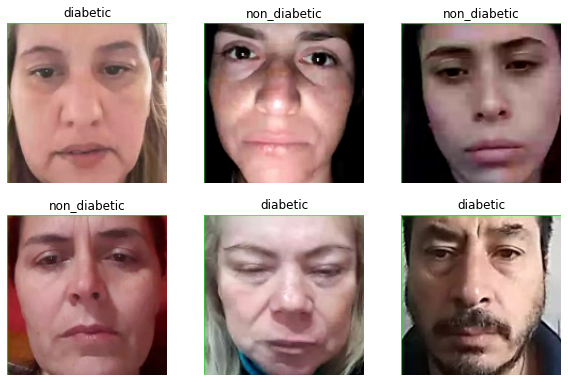

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(6):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
#validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Using random data augmentation

When you don't have a large image dataset, it's a good practice to artificially
 introduce sample diversity by applying random yet realistic transformations to
the training images, such as random horizontal flipping or small random rotations. This
helps expose the model to different aspects of the training data while slowing down
 overfitting.

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.10),
        layers.experimental.preprocessing.RandomZoom(.5, .2),
        layers.experimental.preprocessing.RandomContrast([0.2, 0.8]),
        layers.experimental.preprocessing.RandomTranslation(0.1,0.1),
        
    ]
)

Let's visualize what the first image of the first batch looks like after various random
 transformations:

In [ ]:
train_ds = train_dataset

In [ ]:
validation_ds = test_dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


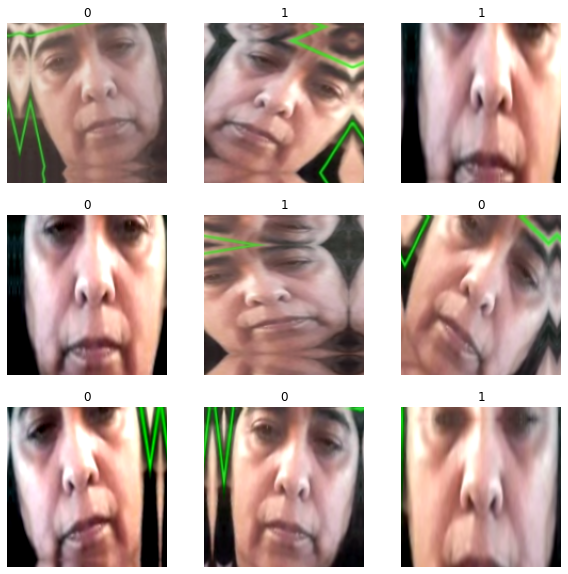

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

## Build a model

Now let's built a model that follows the blueprint we've explained earlier.

Note that:

- We add a `Normalization` layer to scale input values (initially in the `[0, 255]`
 range) to the `[-1, 1]` range.
- We add a `Dropout` layer before the classification layer, for regularization.
- We make sure to pass `training=False` when calling the base model, so that
it runs in inference mode, so that batchnorm statistics don't get updated
even after we unfreeze the base model for fine-tuning.

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x) 
x = keras.layers.Dense(20)(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

83689472/83683744 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
______________________________________________________________

## Train the top layer

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 9
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/9
149/149 [==============================] - 5386s 36s/step - loss: 0.7694 - binary_accuracy: 0.5735 - val_loss: 0.6054 - val_binary_accuracy: 0.6014
Epoch 2/9
149/149 [==============================] - 26s 170ms/step - loss: 0.6377 - binary_accuracy: 0.6342 - val_loss: 0.6069 - val_binary_accuracy: 0.6494
Epoch 3/9
149/149 [==============================] - 25s 159ms/step - loss: 0.6069 - binary_accuracy: 0.6569 - val_loss: 0.6837 - val_binary_accuracy: 0.4861
Epoch 4/9
149/149 [==============================] - 24s 156ms/step - loss: 0.6038 - binary_accuracy: 0.6520 - val_loss: 0.6030 - val_binary_accuracy: 0.6709
Epoch 5/9
149/149 [==============================] - 24s 155ms/step - loss: 0.5805 - binary_accuracy: 0.6706 - val_loss: 0.6055 - val_binary_accuracy: 0.6490
Epoch 6/9
149/149 [==============================] - 24s 155ms/step - loss: 0.5945 - binary_accuracy: 0.6680 - val_loss: 0.5977 - val_binary_accuracy: 0.6359
Epoch 7/9
149/149 [==============================] -

## Do a round of fine-tuning of the entire model

Finally, let's unfreeze the base model and train the entire model end-to-end with a low
 learning rate.

Importantly, although the base model becomes trainable, it is still running in
inference mode since we passed `training=False` when calling it when we built the
model. This means that the batch normalization layers inside won't update their batch
statistics. If they did, they would wreck havoc on the representations learned by the
 model so far.

In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-6),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 60
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 20)                40980 

After 10 epochs, fine-tuning gains us a nice improvement here.